In [2]:
from google.colab import files
updated = files.upload()

Saving salesweekly.csv to salesweekly.csv



Training for M01AB ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


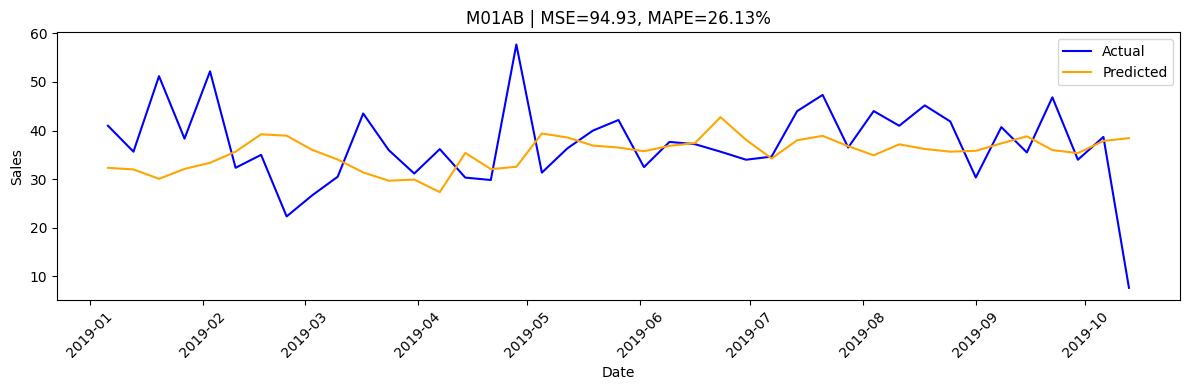


Training for M01AE ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


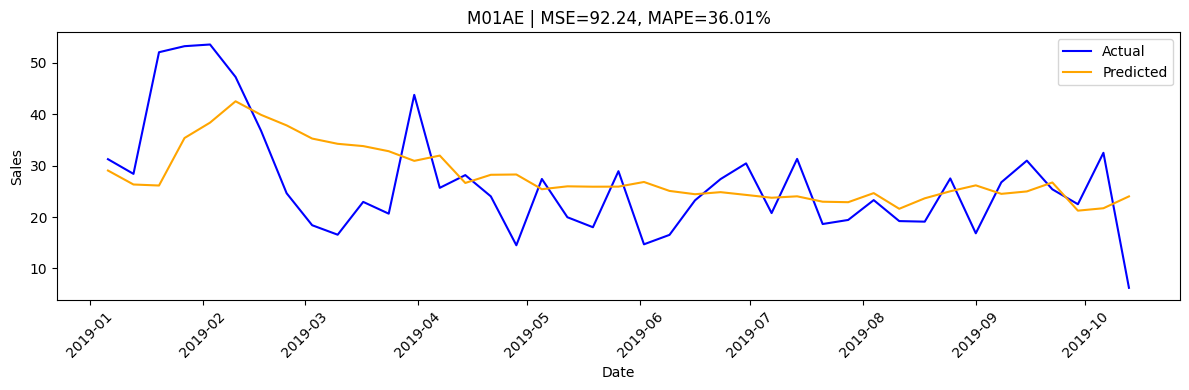


Training for N02BA ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


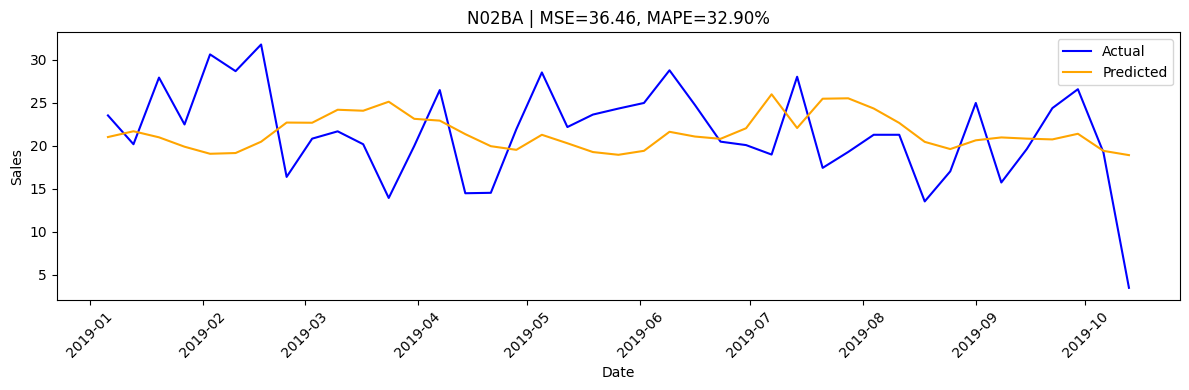


Training for N02BE ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


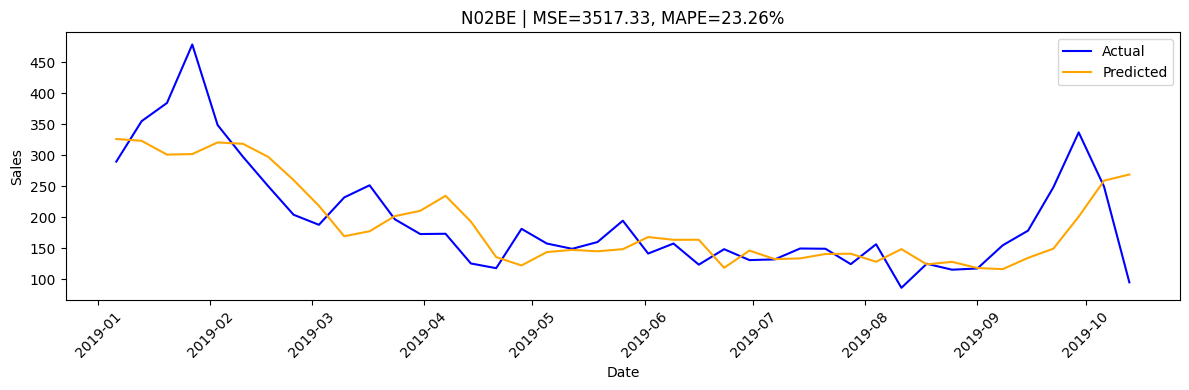


Training for N05B ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


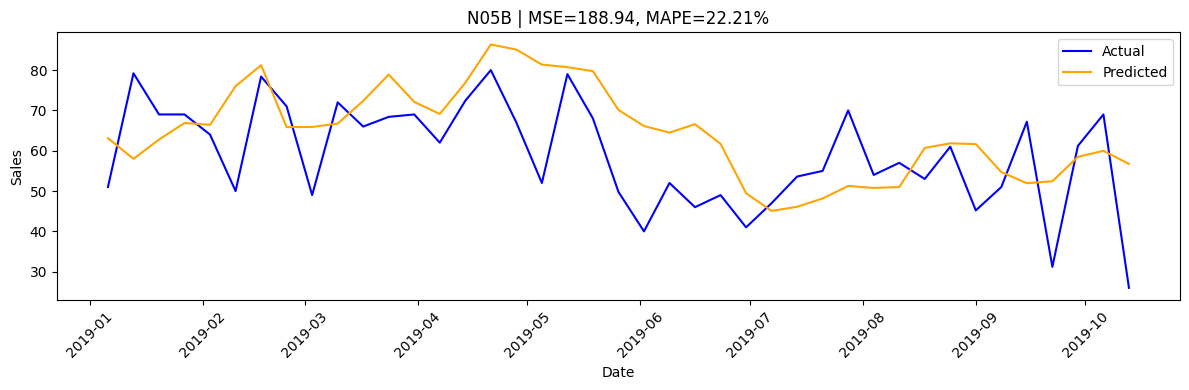


Training for N05C ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


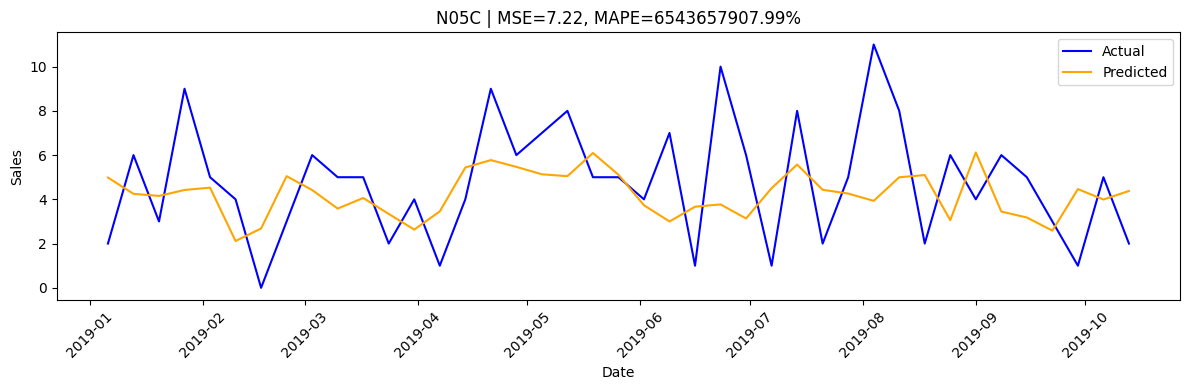


Training for R03 ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


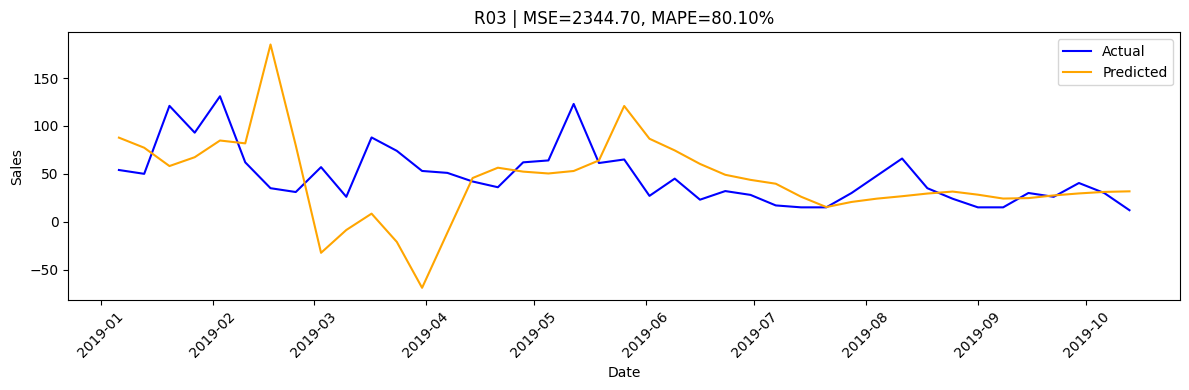


Training for R06 ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


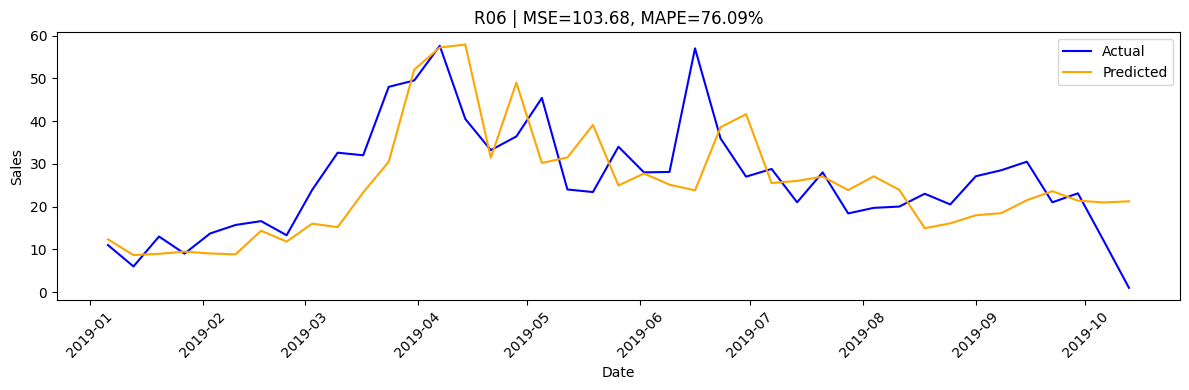

,MSE,MAPE
M01AB,94.925170,2.613089e+01
M01AE,92.241386,3.600689e+01
N02BA,36.458835,3.289506e+01
N02BE,3517.331873,2.326232e+01
N05B,188.939133,2.220576e+01
N05C,7.217362,6.543658e+09
R03,2344.700473,8.010116e+01
R06,103.684893,7.609112e+01


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


N_STEPS = 10
EPOCHS = 300
BATCH_SIZE = 16

tf.random.set_seed(0)
np.random.seed(0)


df = pd.read_csv("salesweekly.csv")
df['datum'] = pd.to_datetime(df['datum'])
codes = ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']


def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(1e-9, y_true))) * 100

def make_supervised(series, n_steps=N_STEPS):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)

def build_stacked_lstm(input_shape):
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(100, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


split_date = '2019-01-01'
results = {}

for drug in codes:
    print(f"\nTraining for {drug} ...")


    series = df[drug].values.reshape(-1,1)


    train_mask = df['datum'] < split_date
    test_mask  = df['datum'] >= split_date

    train_series = series[train_mask].reshape(-1,1)
    test_series  = series[test_mask].reshape(-1,1)


    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_series).flatten()
    test_scaled  = scaler.transform(test_series).flatten()


    X_train, y_train = make_supervised(train_scaled, N_STEPS)
    X_test, y_test   = make_supervised(np.r_[train_scaled[-N_STEPS:], test_scaled], N_STEPS)

    X_train = X_train[..., None]
    X_test  = X_test[..., None]


    model = build_stacked_lstm((N_STEPS, 1))
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)


    y_pred_scaled = model.predict(X_test).flatten()

    y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()


    mse = mean_squared_error(y_true, y_pred)
    mape_score = mape(y_true, y_pred)
    results[drug] = {'MSE': mse, 'MAPE': mape_score}


    test_dates = df.loc[test_mask, 'datum'].iloc[:len(y_true)]


    plt.figure(figsize=(12,4))
    plt.plot(test_dates, y_true, label='Actual', color='blue')
    plt.plot(test_dates, y_pred, label='Predicted', color='orange')
    plt.title(f"{drug} | MSE={mse:.2f}, MAPE={mape_score:.2f}%")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()


    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


pd.DataFrame(results).T
